In [1]:
import dataloader
import pandas as pd
import utils
import preprocessing

In [3]:
config = utils.load_config()

In [4]:
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])

In [5]:
df_dataset = df_dataset.dropna()
img_dataset = dataloader.load_dataset(df_dataset)

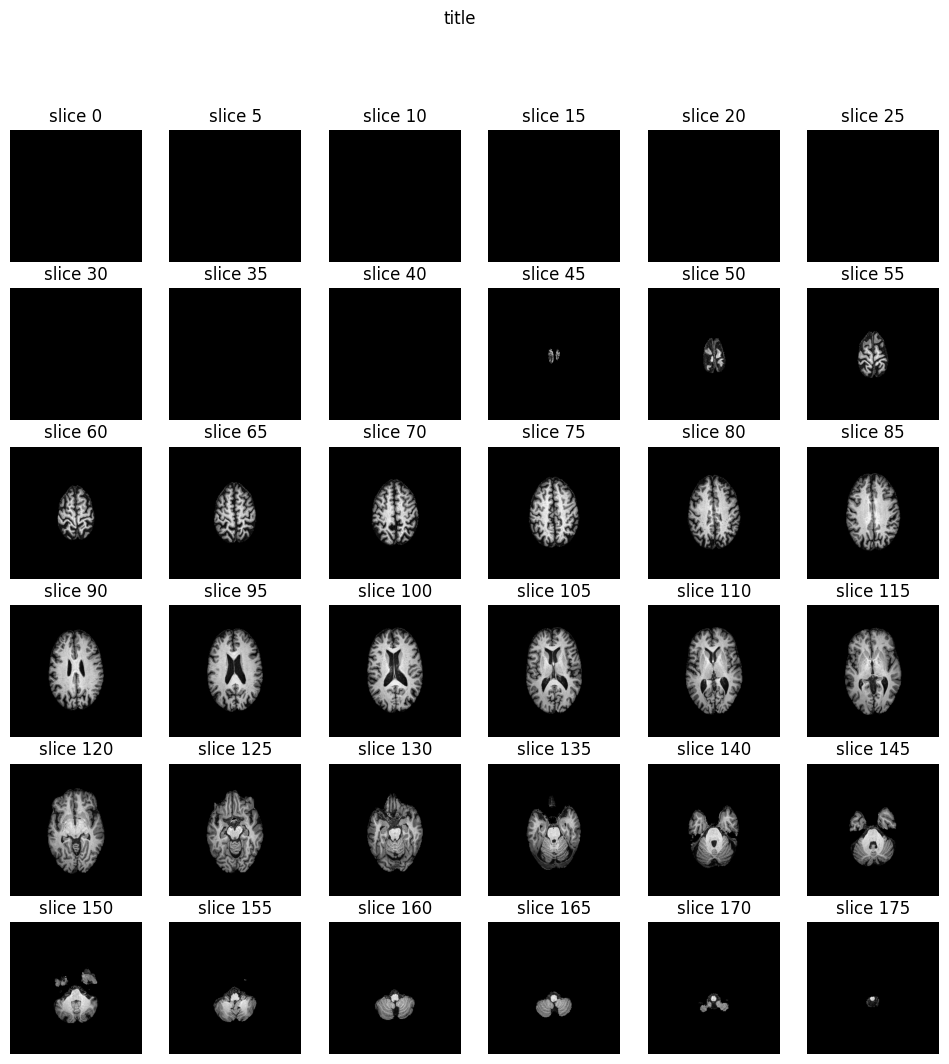

In [6]:
utils.stack_plot(img_dataset[0])

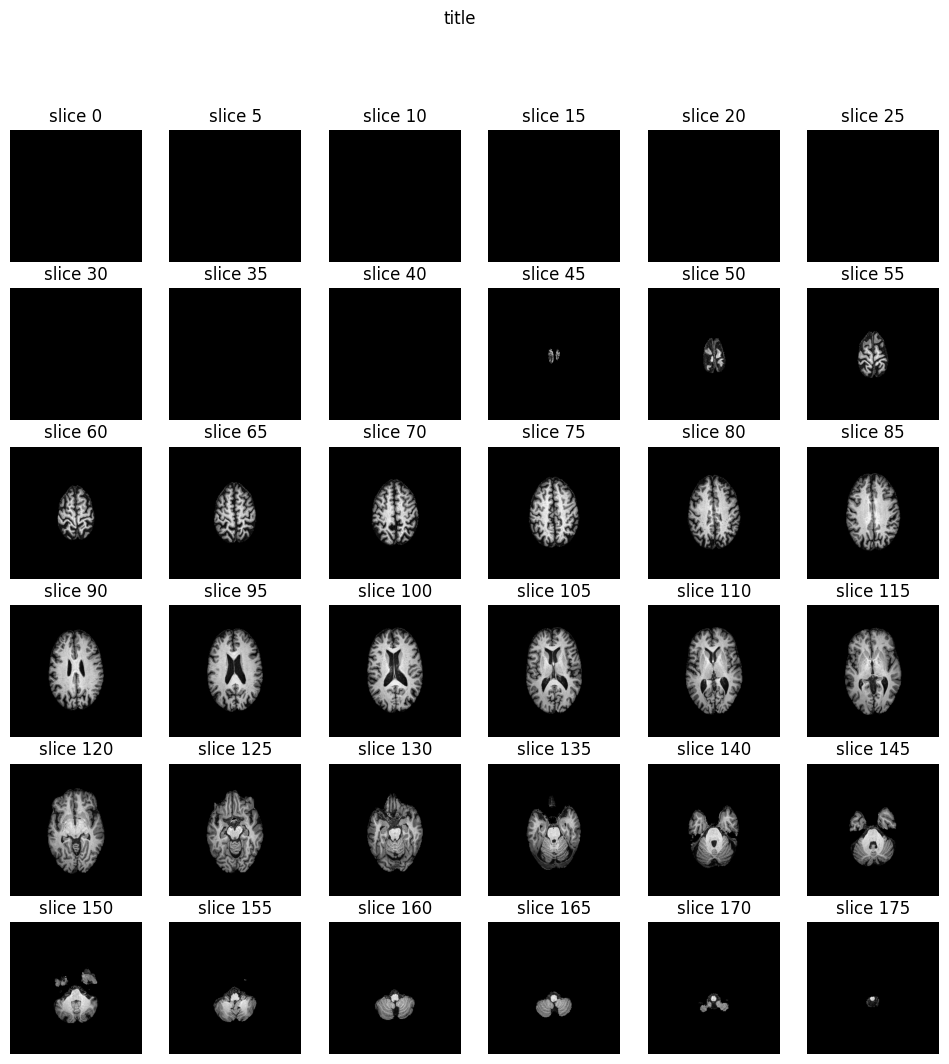

In [8]:
image = img_dataset[0]
image = preprocessing.crop_image(image)
image = preprocessing.add_pad(image)
utils.stack_plot(image)